In [31]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
import time

with open("leg_parametric.xml", "r") as f:
  xml = f.read()

4


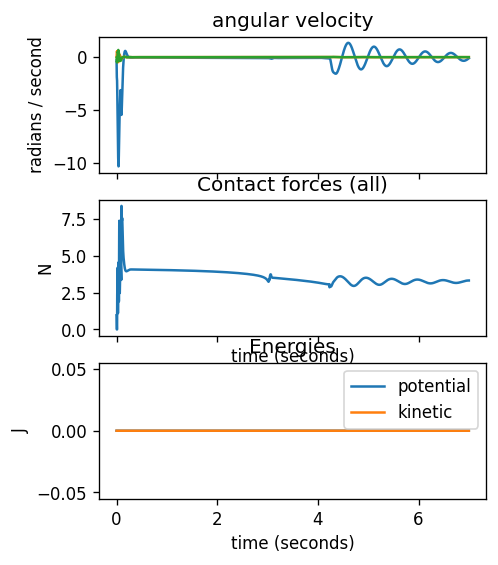

In [33]:
if 'renderer' in locals():
    del renderer
if 'model' in locals():
    del model
if 'data' in locals():
    del data

timevals = []
angular_velocity = []
stem_height = []

potential_energy = []
kinetic_energy = []
contact = []

frames = []
duration = 7    # (seconds)
framerate = 60  # (Hz)

model = mujoco.MjModel.from_xml_string(xml)
renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
print(model.nu)


# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)
i = 0
while data.time < duration:
  data.ctrl = [0, 20, 0, 20]
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  potential_energy.append(data.energy[0])
  kinetic_energy.append(data.energy[1])
  
  forcetorque = np.zeros(6)
  contact.append(0)
  for j,c in enumerate(data.contact):
    mujoco.mj_contactForce(model, data, j, forcetorque)
    contact[i] += np.linalg.norm(forcetorque[0:3])
    #penetration[i] = min(penetration[i], c.dist)

  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2])

  if len(frames) < data.time * framerate:
    #print(data.qfrc_applied)
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)
  i += 1

dpi = 120
width = 500
height = 600
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, contact)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('N')
_ = ax[1].set_title('Contact forces (all)')

ax[2].plot(timevals, potential_energy, label='potential')
ax[2].plot(timevals, kinetic_energy, label='kinetic')
ax[2].set_xlabel('time (seconds)')
ax[2].set_ylabel('J')
ax[2].legend()
_ = ax[2].set_title('Energies')

media.show_video(frames, fps=framerate)